(C) 2024, Gerold Baier, University College London

# Spatio-temporal Oscillations

- Spatio-temporal patterns: symmetry-breaking in time and space
- Boxplots show median / mean and spread of data in a segment
- Histograms show approximate probability distributions of a segment
- Stationarity: statistical measures remain invariant. This is typically violated in the EEG. 
- Representing information processsing, brain activity is ever-changing and non-repeating.

The code below was introduced in the previous class up until __Time Series and Heatmap__. There, __Boxplots, Histograms, and Fourier spectra of Half Segments__ demonstrated the non-stationarity of the EEG.

To get information about relationships __between__ channels (interaction, exchange, communication), we need to calculate __bivariate__ measures. 

Here we look at the Pearson correlation coefficient and the histogram similarity as examples of bivariate analysis. For a more detailed introduction, please see "Dataframes_Bivariate_Analysis.pdf" under Reading. 

A good overview of many different bivariate measures is in [Unifying Pairwise Interactions in Complex Dynamics](https://arxiv.org/abs/2201.11941).


## Import and Functions

In [2]:
from numpy import pi, linspace, sin, diff, arange, asarray, ndarray, zeros, exp, array, linspace, median, gradient, around
from numpy import triu, triu_indices, triu_indices_from, var, mean, std, sqrt, where, isnan, nan_to_num, delete, floor
from numpy import nan, flip, argwhere, ones, diag, correlate, corrcoef, transpose, cov, flip, ceil, cos, sin, arctan
from numpy import angle, exp, amax, amin, absolute, meshgrid, fill_diagonal, concatenate, c_, real, argsort, tile
from numpy import empty_like, zeros_like, log, logical_and, copy, greater, invert, nonzero, count_nonzero, divide, repeat
from numpy import sign, append, hstack, savetxt, loadtxt, histogram

from numpy.random import normal, permutation
from numpy.linalg import norm

from matplotlib.pyplot import subplots, xlabel, ylabel, hist, bar, legend, axis, axes
from matplotlib.pyplot import figure, xticks, yticks, rcParams, show

from scipy.optimize import curve_fit
from scipy.signal   import butter, sosfilt, find_peaks
from scipy.stats    import spearmanr, entropy
from scipy.spatial  import distance
from scipy.cluster  import hierarchy
from scipy.interpolate import interp1d
from scipy.fft import rfft, rfftfreq

from sklearn.preprocessing import MinMaxScaler

from pandas import read_csv, DataFrame

from string import ascii_uppercase

from itertools import product

from math import dist


In [3]:
def eeg_plot(data, offset, normalise=True):
    """
    Plot date columns in EEG style
    data:      two-dimensional array
    offset:    scaling factor
    normalise: normalisation of amplitudes to variance 1
    """
    from matplotlib.pyplot import subplots
    
    start = 0
    samples = data.shape[0]
    electrodes = data.shape[1]

    dataset = data[start:start+samples, :electrodes]
    means = data[start:start+samples, :electrodes].mean(axis=0)
    devs = data[start:start+samples, :electrodes].std(axis=0)

    fig, ax = subplots(figsize=(8, 6))

    if not normalise:
        ax.plot((dataset - means)      + offset*arange(electrodes-1,-1,-1), linewidth=1);
    else:
        ax.plot((dataset - means)/devs + offset*arange(electrodes-1,-1,-1), linewidth=1);
    
    ax.plot(zeros((samples, electrodes)) + offset*arange(electrodes-1,-1,-1),'--',color='gray');
    ax.set(ylabel='Voltage')

    yticks([]);
    
    axis('tight');

    return fig, ax


## Pick Patient, Seizure, Type, and read EEG


In [4]:
# read prefiltered 60 sec segment

folder      = '../Data/'
patient     = '1'         # '1'
seizure     = '03'        # '01' or '02' or '03'
series_type = 'Onset'     # 'Background' or 'Onset' 

sr_chars = folder + 'sampling_rate.txt'

df1 = read_csv(sr_chars, header=None)

sr = df1.iloc[0, 0]

series_chars = folder + 'Pat' + patient + '_Sz' + seizure + '_' + series_type + '_1_100Hz.csv'

df2 = read_csv(series_chars)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = df2.columns[1:]

print('')
print(series_chars)
print('')


../Data/Pat1_Sz03_Onset_1_100Hz.csv



In [5]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict


{'A': [0, 11],
 'B': [11, 22],
 'C': [22, 31],
 'E': [31, 40],
 'F': [40, 49],
 'Z': [49, 56],
 'O': [56, 67],
 'T': [67, 74],
 'U': [74, 81],
 'V': [81, 92],
 'W': [92, 107],
 'X': [107, 122]}

## Settings and Filtering


In [6]:
onset  = (146.7, 147.0, 146.7)


In [7]:
time_max = 60

init_cut  = 25

band_low  = 1
band_high = 100

order = 5

rows_max = int(time_max * sr)

sample_start = int((onset[int(seizure)-1]-30)*sr)
# sample_start = 0

sample_end = sample_start + rows_max

channel_start, channel_stop = 0, data_prefiltered.shape[1]  # Bad channels 81, 82 for 2015lvxiaofu

number_channels = channel_stop - channel_start


data_unfiltered = data_prefiltered[:, channel_start:channel_stop]


sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

data_filtered = zeros((rows_max, number_channels))

for index, column in enumerate(data_unfiltered.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    data_filtered[:, index] = backwards[-1::-1]

data_filtered.shape


(60000, 122)

# Complete EEG


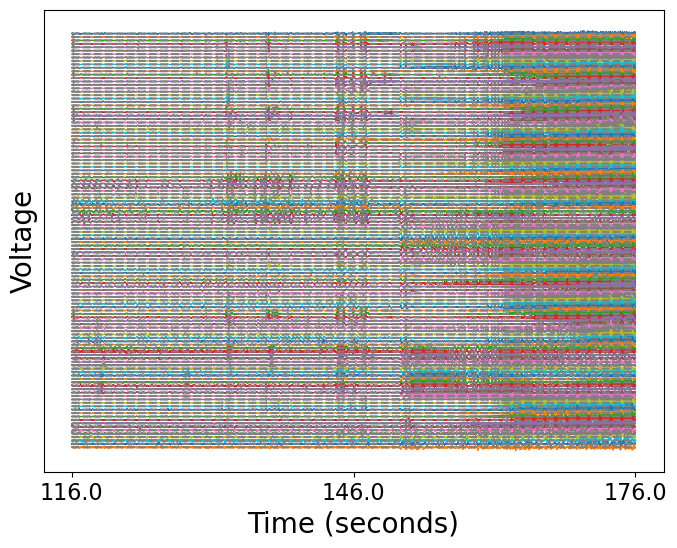

In [8]:
fig, ax = eeg_plot(data_filtered, 5)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(sample_start//sr, sample_start//sr + time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

ax.set_ylabel('Voltage', fontsize=20);

show()


# A Single Electrode


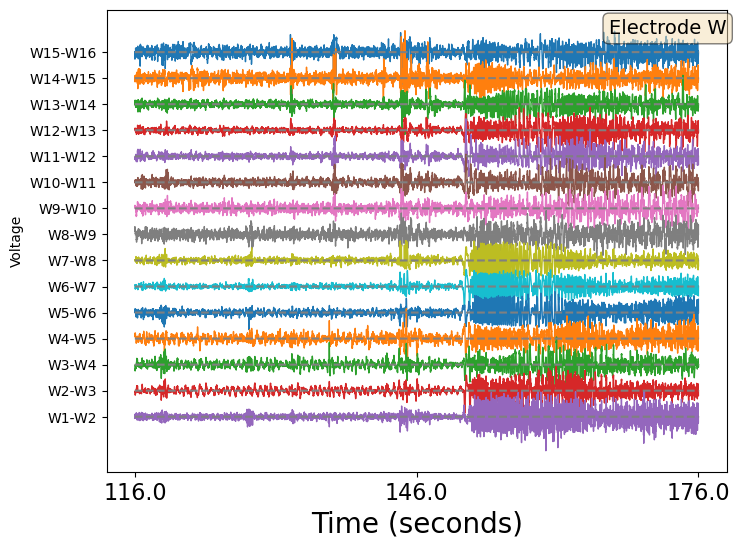

In [9]:
elec_name = 'W'

all_labels_np = asarray(all_labels)

elec_label_names = all_labels_np[label_dict[elec_name][0]:label_dict[elec_name][1]]

data_chan      = data_filtered[:, label_dict[elec_name][0]:label_dict[elec_name][1]]

chans = data_chan.shape[1]

factor = 5

fig, ax = eeg_plot(data_chan, factor, normalise=True)
ax.set_yticks(factor*arange(chans))
ax.set_yticklabels(elec_label_names)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(sample_start//sr, sample_start//sr + time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
textstr = 'Electrode ' + elec_name
ax.text(0.81, 0.98, textstr, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props);

show()


## Pick a Segment and Normalise

In [10]:
seg_start = 30000
seg_stop  = 40000

rows_seg = seg_stop - seg_start

data_chan_seg      = data_chan[seg_start:seg_stop, :]

means              = data_chan_seg.mean(axis=0)
devs               = data_chan_seg.std(axis=0)
data_chan_seg_norm = (data_chan_seg - means)/devs


## Time Series & Heatmap

figs/Sz03_W_timeseries_L1_H100_Start30000.png


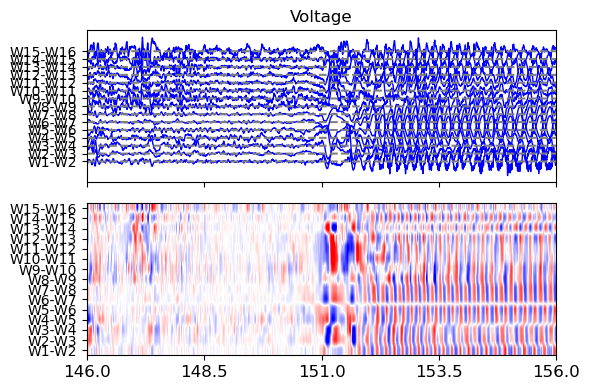

In [11]:
offset = 2

################################### Time Series
fig, (ax1, ax2) = subplots(nrows=2, figsize=(6,4))

### Voltage Series
ax1.plot(data_chan_seg_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax1.plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax1.set_yticks(offset*arange(chans))
ax1.set_yticklabels(elec_label_names)
ax1.margins(x=0)
ax1.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax1.set_xticklabels([], fontsize=12)
ax1.set_title('Voltage', fontsize=12)


### Voltage Heatmap
ax2.imshow(data_chan_seg_norm.T, aspect='auto', cmap='bwr', vmin=-3, vmax=3);
ax2.set_yticks(arange(chans))
ax2.set_yticklabels(flip(elec_label_names));

ax2.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax2.set_xticklabels(labl, fontsize=12)


fig.tight_layout()

title_chars = 'figs/Sz' + seizure + '_' + elec_name + '_timeseries_' + 'L' + str(band_low) + '_H' + str(band_high) + '_Start' + str(seg_start) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)

show()


# Bivariate Analysis

In [12]:
def get_probabilities(data, bins):
    """
    Function to get M probability distributions from an N x M data set
    """

    cnts = zeros(shape=(data.shape[1], bins))

    for index, dat in enumerate(data.T):

        cnt = histogram(dat, bins=bins)[0]

        cnts[index, :] = cnt

    probs = array(cnts)/data.shape[0]
   
    return probs


def jensen_shannon_distance(p, q):
    """
    Function to compute the Jensen-Shannon Distance 
    between two probability distributions
    """

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (entropy(p, m, base=2) + entropy(q, m, base=2)) / 2

    # compute the Jensen Shannon Distance
    distance = sqrt(divergence)

    return distance
 

## Histogram Similarity & Cross-Correlation

The histogram similarity is quantified using the Jensen-Shannon distance (between 0 and 1) between histograms. Cross-correlation is calculated as the Pearson correlation coefficient (between -1 and 1) by pointwise comparison of datapoints in a segment. Both measures are symmetric and are typically displayed in am $N\times N$ matrix. For $N$ time series, there are $N\times(N-1)/2$ simirality coefficients. 

In [13]:
# Histogram Similarity
bins = 50

data_probs = get_probabilities(data_chan_seg_norm, bins)

dist_matrix = zeros(shape=(chans, chans))

mat_indices = triu_indices(chans-1)

for ind, num_1 in enumerate(mat_indices[0]):

    num_2 = mat_indices[1][ind]+1
        
    dist = jensen_shannon_distance(data_probs[num_1, :], data_probs[num_2, :])
    
    dist_matrix[num_1, num_2] = dist

data_chan_seg_dist = dist_matrix + triu(dist_matrix).T

data_chan_seg_sim = 1 - data_chan_seg_dist
fill_diagonal(data_chan_seg_sim, 0)

# Correlation
data_chan_seg_corr = corrcoef(data_chan_seg, rowvar=False)

fill_diagonal(data_chan_seg_corr, 0)

data_chan_seg_corr_abs      = abs(data_chan_seg_corr)


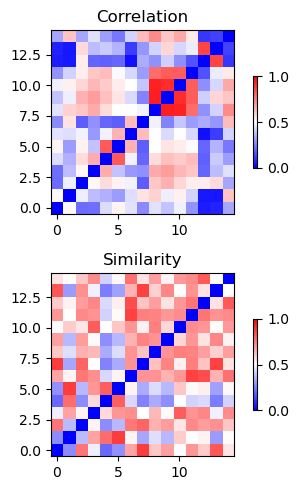

In [14]:
fig, ax = subplots(nrows=2, figsize=(4,5))

# Voltage matrices
im = ax[0].imshow(data_chan_seg_corr_abs, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax[0], ticks=(0, 0.5, 1), shrink = 0.5);
ax[0].set_title('Correlation')

im = ax[1].imshow(data_chan_seg_sim, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax[1], ticks=(0, 0.5, 1), shrink = 0.5);
ax[1].set_title('Similarity');

fig.tight_layout()

show()


In [15]:
######## Correlation
data_chan_seg_corr_1 = corrcoef(data_chan_seg[:rows_seg//2, :], rowvar=False)
data_chan_seg_corr_2 = corrcoef(data_chan_seg[rows_seg//2:, :], rowvar=False)

fill_diagonal(data_chan_seg_corr_1, 0)
fill_diagonal(data_chan_seg_corr_2, 0)

data_chan_seg_corr_abs_1      = abs(data_chan_seg_corr_1)
data_chan_seg_corr_abs_2      = abs(data_chan_seg_corr_2)

######## Jensen-Shannon
bins = 10

# Voltage
data_1, data_2 = data_chan_seg_norm[:rows_seg//2, :], data_chan_seg_norm[rows_seg//2:, :]

data_probs_1 = get_probabilities(data_1, bins)
data_probs_2 = get_probabilities(data_2, bins)

dist_matrix_1 = zeros(shape=(chans, chans))
dist_matrix_2 = zeros(shape=(chans, chans))


mat_indices = triu_indices(chans-1)

for ind, num_1 in enumerate(mat_indices[0]):

    num_2 = mat_indices[1][ind]+1
        
    dist_1      = jensen_shannon_distance(data_probs_1[num_1, :], data_probs_1[num_2, :])
    dist_2      = jensen_shannon_distance(data_probs_2[num_1, :], data_probs_2[num_2, :])
     
    dist_matrix_1[num_1, num_2] = dist_1
    dist_matrix_2[num_1, num_2] = dist_2

data_chan_seg_dist_1 = dist_matrix_1 + triu(dist_matrix_1).T
data_chan_seg_dist_2 = dist_matrix_2 + triu(dist_matrix_2).T

data_chan_seg_sim_1 = 1 - data_chan_seg_dist_1
data_chan_seg_sim_2 = 1 - data_chan_seg_dist_2

fill_diagonal(data_chan_seg_sim_1, 0)
fill_diagonal(data_chan_seg_sim_2, 0)


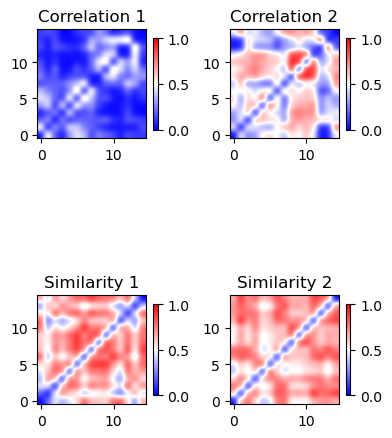

figs/03/W_half_matrices_L1_H100_Start30000.png



In [16]:
################################### Matrices
fig, ax = subplots(nrows=2, ncols=2, figsize=(4, 6))

# Voltage correlations
im = ax[0,0].imshow(data_chan_seg_corr_abs_1, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
fig.colorbar(im, ax=ax[0,0], ticks=(0, 0.5, 1), shrink = 0.3);
ax[0,0].set_title('Correlation 1')

im = ax[0,1].imshow(data_chan_seg_corr_abs_2, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
# im = ax[0,1].imshow(data_chan_seg_sim, cmap='bwr', vmax=1);
fig.colorbar(im, ax=ax[0,1], ticks=(0, 0.5, 1), shrink = 0.3);
ax[0,1].set_title('Correlation 2')

# Voltage similarities
im = ax[1,0].imshow(data_chan_seg_sim_1, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
fig.colorbar(im, ax=ax[1,0], ticks=(0, 0.5, 1), shrink = 0.3);
ax[1,0].set_title('Similarity 1')

im = ax[1,1].imshow(data_chan_seg_sim_2, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
# im = ax[0,1].imshow(data_chan_seg_sim, cmap='bwr', vmax=1);
fig.colorbar(im, ax=ax[1,1], ticks=(0, 0.5, 1), shrink = 0.3);
ax[1,1].set_title('Similarity 2')

fig.tight_layout()

show()

title_chars = 'figs/' + seizure + '/' + elec_name + '_half_matrices_' + 'L' + str(band_low) + '_H' + str(band_high) + '_Start' + str(seg_start) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)
print('')

## Jensen-Shannon and Correlation Differences

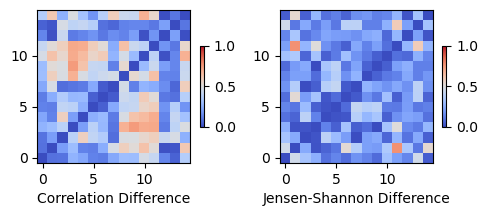

In [21]:
corr_diff = abs(data_chan_seg_corr_abs_2 - data_chan_seg_corr_abs_1)
js_diff   = abs(data_chan_seg_sim_2 - data_chan_seg_sim_1)

fig, ax = subplots(ncols=2, figsize = (5, 3))

im1 = ax[0].imshow(corr_diff, cmap='coolwarm', vmin=0, vmax=1, origin='lower');

im2 = ax[1].imshow(js_diff, cmap='coolwarm', vmin=0, vmax=1, origin='lower');

fig.colorbar(im1, ax=ax[0], orientation='vertical', shrink=0.3);
fig.colorbar(im2, ax=ax[1], orientation='vertical', shrink=0.3);

corr_title_data = 'Correlation Difference'
sims_title_data = 'Jensen-Shannon Difference'

ax[0].set_xlabel(corr_title_data)
ax[1].set_xlabel(sims_title_data)

fig.tight_layout()

title_chars = folder + 'figs/' + seizure + '_correlation_difference.png'
# fig.savefig(title_chars, format='png')
title_chars
print('')

show()


# Summary

Bivariate measures capture the degree of interaction (interrelation, communication) between to datasets. There are a large number of possible measures, each with its own adavntages and disadvantages. 

In our examples, the correlation uses a sample-by-sample comparison of data points and is thus dependent on the temporal order of the voltages. In contrast, the Jensen-Shannon similarity compares data distributions and is thus independent of the temporal order of the voltages. 

Taken together, uni- and bivariate measures can be used to create network representations of dynamical systems. 


# Try It Yourself

> Pick data from different electrodes and select segments with contrasting dynamics to re-run the code. Try to get all the way down to the difference matrices to see how localised or diffuse the main differences between the two halves of a segment are.


In [ ]:
fig.savefig('/figures/my_figure.png', format='png', tr)
# 